This notebook contains my code for the implementation of the first project for the [Deep Reinforcement Learning Nanodree](https://eu.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) at [Udacity](https://eu.udacity.com).

**Note** Some of the cells in the notebook include training steps that might take a log time to run, so please be aware of this before attempting to "Run All" cells on your local copy of the notebook. For convenience the Github repository includes a PDF export of this Notebook (you might actually be reading this one), that has the advantage that it includes all the output nicely formatted for easy reading. Where possible, I have saved the information resulted from training and the code can be run either with training or by reading that information from the saved files.

# Background

The Navigation project requires navigation in a large sqare world by using one of the 4 actions (`0` move forward, `1` move backward, `2` turn left and `3` turn right) in order to collect yellow bananas (reward +1) while avoiding blue bananas (reward -1). To "solve" the problem the agent will need to score more then +13 over 100 consecutive episodes. We also aim to reach that score before executing 1700 episodes.

The simulation environment is provided as an Unity application and the interaction with this environment is provided in a convenient Python wrapper where the agent can perform actions (one of the four listed above) and returns a `state` vector of size 37 (that includes information about the current velocity and locations of bananas in the field of view).

**Note** Before you run this notebook on your machine you should first installed the required dependencies as described in the README.md file in the Github repository.

# Project

## Preparations

We will first include all the parts that we need for this project.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from collections import namedtuple, deque
import random
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment

We will now create the simulation environment. This will list a number of charateristics, and please pay attention to the *Vector Observation space size* and *Vector Action space size* that are representing the two important features for Reinforcement Learning, the **State** space, respectively the **Action** space.

**Note:** I am running this on a MacBook and the simulation environment is and app called "Banana.app" that is located in the same folder as this notebook. If you use the another OS follow the instructions in the README.md to install the simulator specific for your OS and update the `file_name` parameter in the call bellow.

In [2]:
env = UnityEnvironment(file_name='Banana.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


To make things easier later, we will save some of the parameters from the environment in several global variables that we will use throughout the code. Since the environment has only one **Brain** (learn more about the Unity data model [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Readme.md)), we will hard-code the access to this data with this assumption.

In [3]:
# there is only one Brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# save the state size and the action size
env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

print('State size : ' + str(state_size))
print('Action size: ' + str(action_size))

State size : 37
Action size: 4


As expected the `state_size` is 37 and the `action_size` is 4.

Later on in the notebook we will take advantage of pytorch cababilities to use GPUs when performing the calculations. We will at this moment determine if the current machine has a supported GPU and declare that as the device to use.

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Now we will just simply pass `device` when manipulating pytorch structures and it will take advantage of any GPU support, if avaialble.

## Starting Easy

We will now start with the proper implementation of the agent.

### Model Class

First we will need to implement the Neural Network (NN) that will calculate the Q function for this problem. Given that the state space is relatively small (37) and it does not include any visual images we will choose to implement this using Fully Connected (FC) NN. But to keep things flexible we will prepare a class QNetwork that will allow us to create FC NN of different depths (number of layers) as well as number of neurons per layer. Naturally the input layer will be determined by the state space and the output layer by the action space. In between we can create an arbitrary number of hidden layer with an arbitrary number of neurons.

The constructor for the class will require:

- the `state_size`: input size of the state space
- the `action_size`: the output size of the action space
- the `units`: repreasenting a list containing the number of neurons for each hidden layer
- a optional `seed` that can be used to initialize the random generators

The `forward` method simply passes the data through all the layers.

All layers, except the last one will use ReLU activation functions.

In principle, the `torch` guideline is to define the layers in the `__init__` method and implement the activations in the `forward` method. I personally prefer to include the activations in the `__init__` as this will allow for a nicer print of the network, one that includes the activations as well. If the activations are defined in the `forward` function they are not included when printing a network and we would need to go throguh the code to figure out which layers use which activations. You will see later in the notebook what I mean by that.

In [5]:
class QNetwok(torch.nn.Module):
    """A Fully Connected NN with configurable number of
       layers and number of neurons within each layer.
    """
        
    def __init__(self, state_size, action_size, 
                 units=[64, 64], seed=None):
        """Initialize the NN
        
        Params
        ======
            state_size (int): Dimension of state size (input to NN)
            action_size (int): Dimension of action space (output of NN)
            units (list of int): list with the number of neurons per layer
            seed (int): seed for the random generator
        """

        super(QNetwok, self).__init__()
        self.seed = torch.manual_seed(seed) if seed != None else None
        self.n_layers = len(units)+1
        fc = []
        for k in range(self.n_layers):
            if k == 0:
                # first layer - use the state_size
                fc.append(nn.Linear(state_size, units[0]))
                fc.append(nn.ReLU())
                # to look nice when printing network
            elif k == self.n_layers-1:
                # last layer - use the action_size; no ReLU
                fc.append(nn.Linear(units[k-1], action_size))
            else:
                fc.append(nn.Linear(units[k-1], units[k]))
                fc.append(nn.ReLU())
        self.fc = nn.ModuleList(fc) 
        
    def forward(self, state):
        x = state
        for layer in self.fc:
            x = layer(x)
        return x

Let's see what this does. A default `QNetwork` would look like this:

In [6]:
q1 = QNetwok(state_size, action_size)
q1

QNetwok(
  (fc): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

You can see above what I meant by a nicer print. The network has been created with:

- 3 layers in total (2 hidden and one final)
- first layer with input size 37 (mathing the `state_size`) and output 64 (as defined in the `units`), followed by a ReLU activation
- a second layer with input 64 and output 64, followed by ReLU activation
- a last layer with input 64 and output 4, this layer does not have any additional activations

Let's try another one:

In [7]:
q2 = QNetwok(state_size, action_size, units=[64, 128, 64, 32])
q2

QNetwok(
  (fc): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
)

Let's see how the network behaves. If we create a random tensor for state what will we get in the action state?

In [8]:
a_state = torch.from_numpy(np.random.random(37)).float()
a_state

tensor([ 0.9189,  0.0543,  0.6454,  0.8569,  0.6425,  0.9822,  0.3565,
         0.5598,  0.7428,  0.9010,  0.0962,  0.1939,  0.9188,  0.4130,
         0.7538,  0.4944,  0.3099,  0.8656,  0.2356,  0.3562,  0.0343,
         0.5223,  0.8013,  0.0679,  0.9036,  0.2313,  0.0609,  0.0776,
         0.8133,  0.5425,  0.6678,  0.4972,  0.2589,  0.4477,  0.7987,
         0.9005,  0.4055])

In [9]:
q1(a_state)

tensor([ 0.1051, -0.0411,  0.2845,  0.1331])

We seem to be getting a tensor of correct size (4) and the values are aupposed to represent the expectation of total reward if each of those 4 actions are executed, starting from the current state. You also understand now why the last layer does not inlcude any activation function: we want to be able to represent in this output a very large range, both in the positive and negative area. If we included a ReLU activation, this layer would only output poisitive values, thus deleting any information about negative experiences. You also understand why other activations like sigmoid, tanh, etc. would not perform well here: since they are bounded in the [0,1] or [-1,1] range we would loose information related to possible large rewards or penalties that can be accumulated during several hundrends of steps in an episode.

### The Simple Agent class

We now need to define a class that will make use of the Model class above to implement the policy and deal with the apprach for learning the Q function.

Let us fist implement a very simple agent that:

- will use one QNetwork to learn the Q function for the environment
- will learn at each step (there will be no memory)
- will use an $\epsilon$-greedy policy for selecting the action

In [10]:
class SimpleAgent():
    """A Simple Agent that uses just a single NN to calculate
    the Q values and determine actions.
    """
    
    def __init__(self, state_size, action_size, units, seed=None,
                 lr=0.001, gamma=0.99):
        """Initialize the Simple Agent
        
        Params
        ======
            state_size (int): the size of the state space
            action_size (int): the size of the action space
            units (list): a list of the FC layers sizes
            seed (int): random seed
            lr (float): learning rate; used by the optimizer
            gamma (float): discount factor for future rewards
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.units = units
        self.lr = lr
        self.gamma = gamma
        
        # the network
        self.qNetwork = QNetwok(state_size, action_size, units, seed).to(device)
        
        # optimizer; we use Adam
        self.optimizer = optim.Adam(self.qNetwork.parameters(), lr=self.lr)
        
    def step(self, state, action, reward, next_state, done):
        """Reacts to a step in the environment.
        
        Params
        ======
            state (list of float): start state for the action
            action (int): action performed
            reward (int): reward obtained (+1/-1)
            next_state (list of float): new state after action
            done (0/1): indicates the eposode has finished (1)
        """
        # In the case of a simple agent we will learn at every step
        # First detrmine the Q(next)
        self.qNetwork.eval()
        next_state = torch.from_numpy(next_state).float().to(device)
        with torch.no_grad():
            Q_next = self.qNetwork(next_state).detach().max()
        Q_target = reward + (self.gamma * Q_next *(1-done))
        self.qNetwork.train()
        
        # now Q(current)
        state = torch.from_numpy(state).float().to(device)
        Q_expected = self.qNetwork(state)[action]
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
    def act(self, state, eps=0.0):
        """Returns action for curent state as inferred by the NN
        
        Params
        ======
            state (array like): current state
            eps (float): ε for $\epsilon$-greedy action selection
        """
        # to put the state through the NN we need to cnvert to tensor
        state = torch.from_numpy(state).float().to(device)

        # set NN in eval mode
        self.qNetwork.eval()
        with torch.no_grad():
            action_values = self.qNetwork(state)
        self.qNetwork.train()
        
        # $\epsilon$-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
                
    def save(self, filename):
        """Save the model parameters.
        
        Params
        ======
            filename (str): a string for identifying the save\
            
            The method will combine the class name (SimpleAgent) with the
            configuration and the provided string to create a more 
            specific name for the file, for example:
            
            SimpleAgent-64-64-checkpoint.pth
        """
        size_name = ''
        for layer_size in self.units:
            size_name += '-'+str(layer_size)
        filename = 'models/' + self.__class__.__name__ + \
                size_name + '-' + filename
        torch.save(self.qNetwork.state_dict(), filename)

The `act` method is used to return an action for a given state. It puts the network in valuation mode and no gradients are computed. It simply puts the state through the NN getting an expected value for each action. We then chose the action using an $\epsilon$-greedy policy:

- we chose with probalibility 1-$\epsilon$ the action with the maximum value
- we chose with probablity $\epsilon$ a random action from _all_ the action space (including the maximum value action)

The `step` method is used to let the agent deal with the results of one step in the environment. For this agent the mothod applies the Bellman equation to compute a *target* Q value as defined by reward plus a discounted estimated Q value of the next state. This estimated value is determined by running the next_state thrhough the NN and selecting the maximum value across the actions possible in that state.

We also calculate an expected value for the current state by putting it through the NN. This calculation is done in train mode for the NN as we want to later be able to change the weights. The two values (tartget and expected) are then passed to a MSE loss function that will calculate the error for the optimizer.

### We Need A Trainer

Before we start testing this Agent we will also produce a help function called `trainer` that will deal with the environment interaction and will manage the execution of the episodes.



In [11]:
def trainer(agent, n_episodes=2000, max_t=1000,
            eps_start = 1.0, eps_end=0.01, eps_decay=0.995, 
            verbose=False, 
            save=True,
            save_postfix='checkpoint.pth',
            threshold=13.0):
    """A help function that will handle the interaction with the environment
    and manage the agent.
    
    Params:
    ======
        agent (and Agent class): the agent that will be trained; the Agent
                must implement the methods `act`, `step` and `save`
        n_episodes (int): maximum number of episodes the trainer will run
        max_t (int): maximum number of steps in an episode to run unless
                environment returns `done`
        eps_start (float): the ε at the start of training
        eps_end (float): the minumum value for ε
        eps_decay (float): decay factor for ε after each episode
        verbose (Bool): indicate if intermediate (every 100 episodes) are listed
        save (Bool): saves the model if problem solved
        save_postfix (str): is the text that will be added at the end of 
                the save file for the model
        threshold (float): the treshold for considering the problem solved
    """
    print_str = '\rEpisode {}\tAverage Score: {:.2f}\tEpisode: {:.3f}s\tRunning: {:.1f}s'
    
    # variable to store the results
    results = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    tot_dur = 0.0
    
    for i_episode in range(1, n_episodes+1):
        
        start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # run one episode
        for t in range(max_t):
            # determine action
            action = agent.act(state, eps)
            
            # take the action; get the environment response
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 
            
            # ask agent to process the results
            agent.step(state, action, reward, next_state, done)
            
            # cumulate and move to next
            state = next_state
            score += reward
            if done:
                # unless episode complete
                break

        # at the end of the episode keep track of time and scores
        duration = time.time() - start
        tot_dur += duration
        scores_window.append(score)
        avg = np.mean(scores_window)
        results.append((score, avg, duration))
        
        # decay epsilon
        eps = max(eps_end, eps_decay*eps)
        
        # print current numbers
        print(print_str.format(i_episode, avg, duration, tot_dur), end="")
        if i_episode % 100 == 0 and verbose:
            print(print_str.format(i_episode, avg, duration, tot_dur))
            
        # if solved
        if avg >= threshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\t In {:.1f}s'\
                  .format(i_episode, avg, tot_dur))
            if save:
                agent.save(save_postfix)
            break
            
    # check if we finished all episodes but not found a solution
    if avg < threshold:
        print('\nFailed to converge in {:d} episodes.\tAverage Score: {:.2f}\t In {:.1f}s'\
              .format(n_episodes, avg, tot_dur))
        
    # return results for analysis
    return results

The function will try to train the `agent` by running up to `n_episodes` until the average reward over 100 episodes exceeds `threshold` (by default 13). It employs a decaying ε from a start value `eps_start` (1.0 by default meaning fully random action selection) until `eps_end` (0.01 by default meaning at that stage in 99% of cases the agent will chose the most valuable action according to the calculations and in 1% of cases will chose random).


### First Try

We will now try to train an agent and display the results.

In [12]:
# we create an Simple Agent with [64, 64] hidden layers
agent1 = SimpleAgent(state_size, action_size, units=[64, 64], seed=0)
agent1.qNetwork

QNetwok(
  (fc): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

We will now try to train this agent. If you run the following cell **it might take up to 20 minute to complete**! You can instead skip this cell and run the one after this that will load the results from a file. You can then do the plots and analyse the data.

In [13]:
# let's see if it solves the problem
results = trainer(agent1, verbose=True, save=False)

# save the data
f = open('results/SimpleAgent-64-64-results.dat', 'wb')
pickle.dump(results, f)
f.close()

Episode 100	Average Score: -0.06	Episode: 0.838s	Running: 84.6s
Episode 200	Average Score: 0.02	Episode: 0.790s	Running: 167.0s
Episode 300	Average Score: 0.05	Episode: 0.841s	Running: 250.4ss
Episode 400	Average Score: -0.06	Episode: 0.840s	Running: 336.4s
Episode 500	Average Score: 0.10	Episode: 0.839s	Running: 424.9ss
Episode 600	Average Score: -0.06	Episode: 0.864s	Running: 510.2s
Episode 700	Average Score: 0.00	Episode: 0.851s	Running: 595.3ss
Episode 800	Average Score: 0.14	Episode: 0.850s	Running: 680.6ss
Episode 900	Average Score: 0.05	Episode: 0.865s	Running: 765.9s
Episode 1000	Average Score: 0.02	Episode: 0.848s	Running: 851.2s
Episode 1100	Average Score: -0.06	Episode: 0.855s	Running: 940.0s
Episode 1200	Average Score: -0.13	Episode: 0.876s	Running: 1029.7s
Episode 1300	Average Score: 0.00	Episode: 0.858s	Running: 1124.5ss
Episode 1400	Average Score: 0.03	Episode: 0.856s	Running: 1209.9ss
Episode 1500	Average Score: 0.07	Episode: 0.853s	Running: 1295.4ss
Episode 1600	Averag

In [13]:
# read the results from file; use this to analyse data avoiding
# retraining
f = open('results/SimpleAgent-64-64-results.dat', 'rb')
results = pickle.load(f)
f.close()

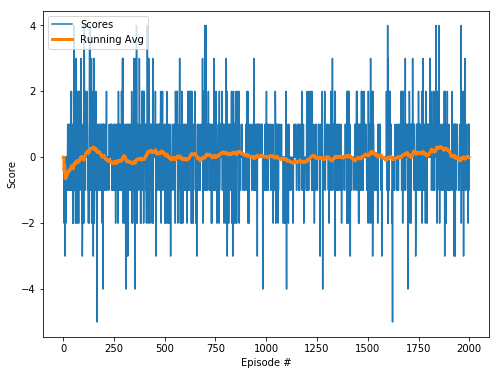

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(results)), [result[0] for result in results])
plt.plot(np.arange(len(results)), [result[1] for result in results], linewidth=3)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Scores', 'Running Avg'], loc='upper left')
plt.show()

This particular run was dissapointing: the Agent failed to learn anything and has barely oscillated around an average of 0. The reality is that more often than not this Agent will behave very poorly and it will very rarely manage to converge within that 2000 number of episodes.

The main issues with this model are:

- uses the same network to evaluate the target and the expected Q values hence being prone to "moving target" syndrome
- learns only from one experiance at a time step; this means we need a large number of steps to be able to gether enough information for training

## DQN Agent

We will try to address the problems above by:

- introducing a second NN in the Agent that will be used to evaluate the target Q values, but will not be subject to any learning. Instead, periodically the learned values from "operational" NN will be used to adjust the parameters of the target NN.
- we will use **experience replay** where experiences from the interaction with the environment are stored in a **memory** and periodically we will sample this memory for a batch of experiences that we will use for training. This way we have the advantage that we can increase significantly the number of training events that are used, and the random nature of these samples will help with reducing the bias produced by being in a partticular state.


### Memory First

Let's first define a class that will handle the management of the experiences and the sampling:

In [15]:
# for convenience
Experience = namedtuple('Experience', 
            field_names=['state', 'action', 'reward', 'next_state', 'done'])


class ReplayBuffer:
    """A class that will handle the experience memory.
    """
    
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer
        
        Params:
        ======
            buffer_size (int): how large the memory buffer will be
            batch_size (int): how many experiences will be extracted when
                sample is called
            seed (int): a seed for random generator
        """
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Adds an experience to the memory
        """
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Extracts a random sample of size `batch_size`
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # preproceses the components to tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences \
                        if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences \
                        if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences \
                        if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences \
                        if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences \
                        if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Allows calling len(memory)
        """
        return len(self.memory)

### A Better Agent

And now we can define the new Agent:

In [16]:
class DQNAgent():
    """A DQN Agent that uses two NN to calculate
    the Q values and determine actions.
    Uses also a memory for storage of experiences for replay
    """
    
    
    def __init__(self, state_size, action_size, units, seed=None,
                lr=0.001, gamma=0.99,
                buffer_size=10000, batch_size=64,
                tau=1e-3, update_every=16):
        """Initialize the Simple Agent
        
        Params
        ======
            state_size (int): the size of the state space
            action_size (int): the size of the action space
            units (list): a list of the FC layers sizes
            seed (int): random generator seed
            lr (float): learning rate for the optimizer
            gamma (float): discount factor for future rewards
            buffer_size (int): size of the replay memory
            batch_size (int): size of sampling batch from memory
            tau (float): factor for trainng of the target NN
            update_every (int): after how many steps a learning step happens
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed) if seed != None else None
        self.units = units
        self.update_every = update_every
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        
        # the network
        self.qNetwork_local = QNetwok(state_size, action_size, units, seed).to(device)
        self.qNetwork_target = QNetwok(state_size, action_size, units, seed).to(device)
        
        # optimizer; we use Adam; we update qNetwork_local parameters
        self.optimizer = optim.Adam(self.qNetwork_local.parameters(), lr=lr)
        
        # replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        
        # initialize time step
        self.t_step = 0

        
    def step(self, state, action, reward, next_state, done):
        """Updates the Agent to a step in the environment
        """
        
        # Add experience to memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Every UPDATE_EVERY trigger learning
        self.t_step = (self.t_step +1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

                
    def act(self, state, eps=0.0):
        """Returns action for curent state as inferred by the NN
        
        Params
        ======
            state (array like): current state
            eps (float): epsilon for epsilon-greedy action selection
        """
        # convert to tensor to run through the NN
        state = torch.from_numpy(state).float().to(device)
        
        # set NN in eval mode and get the actions from local NN
        self.qNetwork_local.eval()
        with torch.no_grad():
            action_values = self.qNetwork_local(state)
        self.qNetwork_local.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

        
    def learn(self, experiences, gamma):
        """Adjust the local NN based on the replayed experiences
        
        Params:
        ======
            experiances (list of Experiences)
            gamma (float): a discount factor for future rewards
        """
        # unpack experiences
        states, actions, rewards, next_states, dones = experiences
        
        # Q(next) predictions from the target model
        Q_targets_next = self.qNetwork_target(next_states).detach()
        Q_targets_next = Q_targets_next.max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next *(1-dones))
        
        # Q() expected from local model
        Q_expected = self.qNetwork_local(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qNetwork_local, self.qNetwork_target, self.tau)

        
    def soft_update(self, local_model, target_model, tau):
        """Updates the target NN from local NN by using a 
        TAU `learning rate`
        
        Params:
        ======
            local_model (NN model): the source of the information
            target_model (NN model): the destination of the updates
            tau (float): a learning rate type factor
        """
        for target_param, local_param in zip(target_model.parameters(),
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + \
                                    (1.0-tau)*target_param.data)
        
    def save(self, filename):
        """Save the model parameters.
        
        Params
        ======
            filename (str): a string for identifying the save
            
            The method will combine the class name (SimpleAgent) with the
            configuration and the provided string to create a more 
            specific name for the file, for example:
            
            DQNAgent-64-64-local-checkpoint.pth
            DQNAgent-64-64-target-checkpoint.pth
        """

        size_name = ''
        for layer_size in self.units:
            size_name += '-'+str(layer_size)
        filename_local = 'models/' + self.__class__.__name__ + \
            size_name + '-local-' + filename
        filename_target = 'models/' + self.__class__.__name__ + \
            size_name + '-target-' + filename
        torch.save(self.qNetwork_local.state_dict(), filename_local)
        torch.save(self.qNetwork_target.state_dict(), filename_target)

The agent uses 2 NN: one for the local processing and one that will be used for target Q values. The second one will not be trained. In addition in the constructor we reserve the space for the replay memory.

The `step` method this time just adds the newly recieved experiance to the memory and every `update_every` invokes the training process.

This is implemented in `learn` method and one of the very big differences from the previous agent is that this training is done for a random sample of experiences (the number is controlled by the variable `batch_size`). As long as the `update_every` is smaller than `batch_size` the result is that the training process will consider more training samples than the first model. For example, in the case of default values for the two variables (16 for `update_every` and 64 for `batch_size`) we actually end up training the mondel on a 4 times more experiences than the SimpleAgent we saw earlier. This, combined with the fact that the experiences are selected randomly from a large memory, contributes to a mcch better performance overall.

The `learn` method uses a parametrized update of the target network, similar to a learning rate when updating weights in a NN.

### Second Try

Let's see how this behaves. As before we will create an agent with [64, 64] networks and keep the rest of the parameters default.

**Note** the next cell will take about 10 mins to run on a normal computer. You can skip this cell and move straight to the next one to visualize the result, unsing the numbers that were produced by the run I did.

In [29]:
# we create an Simple Agent with [64, 64] hidden layers
agent2 = DQNAgent(state_size, action_size, units=[64, 64], seed=0)

# let's see if it solves the problem
results = trainer(agent2, verbose=True, save=False)

# save the results
f = open('results/DQNAgent-64-64-try2.dat', 'wb')
pickle.dump(results, f)
f.close()

Episode 100	Average Score: 0.18	Episode: 0.805s	Running: 97.0s
Episode 200	Average Score: 2.82	Episode: 0.803s	Running: 172.1s
Episode 300	Average Score: 4.75	Episode: 0.676s	Running: 246.4s
Episode 400	Average Score: 6.44	Episode: 0.798s	Running: 322.1s
Episode 500	Average Score: 8.14	Episode: 0.684s	Running: 396.0s
Episode 600	Average Score: 8.96	Episode: 0.718s	Running: 469.8s
Episode 700	Average Score: 8.93	Episode: 0.710s	Running: 544.1s
Episode 800	Average Score: 11.15	Episode: 0.738s	Running: 621.3s
Episode 879	Average Score: 13.02	Episode: 0.688s	Running: 681.1s
Environment solved in 879 episodes!	Average Score: 13.02	 In 681.1s


Great! The agent seems to converge relatively good and (at least in the case above we solved the problem in 879 episodes, well bellow the challenge 1700 suggested in the project guidelines.

Let us display the results from the training:

In [17]:
# read the results from file; use this to analyse data avoiding
# retraining
f = open('results/DQNAgent-64-64-try2.dat', 'rb')
results = pickle.load(f)
f.close()

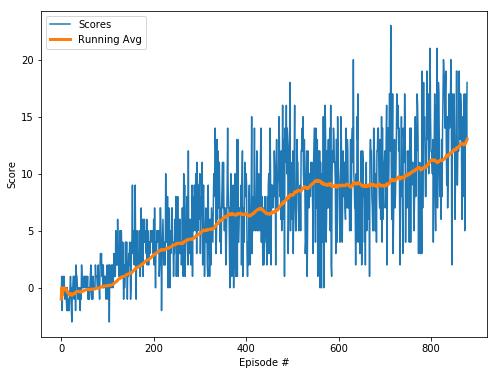

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(results)), [result[0] for result in results])
plt.plot(np.arange(len(results)), [result[1] for result in results], linewidth=3)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Scores', 'Running Avg'], loc='upper left')
plt.show()

It's interesting to notice that after a relatively constant growth of the score there is short period of a flat plateau (aproximately between epoisodes 550 and 700) with a score of around 9.0. This seems to be a common occurence, although the plateau might be higher or lower sometimes.

We obviously want to see if we can do better than this. Let's see if we can determine if there is an impact of the structure of the NN in the model on the laerning performance.

### Studying the Impact of the Model

We will check the impact of different models for the NN in the agent. We will try networks with the following structures:

- [32. 32] that means three layers (37,32), (32,32) and (32, 4)
- [32, 32, 32] that means four layers (37,32), (32,32), (32,32) and (32,4)
- [64, 64] similar to the first one but with 64 neurons in eash layer
- [64, 64, 64] similar to the second one but with 64 neurons in eash layer
- [128, 128]
- [128, 128, 128]

In [19]:
models = [[32,32], [32,32,32],
          [64,64], [64,64,64],
          [128,128], [128,128,128]]

**Note** running the next cell maight take up to one hour on the normal computer as we are running the training 6 times for 6 models. If you only want to see the results jump straight to the next cell that will load the saved data of my run, ready for you to analyze.

In [35]:
for model in models:
    
    print('Training for model: {}'.format(repr(model)))
    agent = DQNAgent(state_size, action_size, model, seed=0)
    # we will also save the weights of the NNs
    results = trainer(agent, verbose=False, 
                      save=True, save_postfix='ModelImpact.pth')

    # save the results
    filename = 'results/DQNAgent-'+repr(model)+'-ModelImpact.dat'
    f = open(filename, 'wb')
    pickle.dump(results, f)
    f.close()

Training for model: [32, 32]
Episode 886	Average Score: 13.10	Episode: 0.698s	Running: 657.2s
Environment solved in 886 episodes!	Average Score: 13.10	 In 657.2s
Training for model: [32, 32, 32]
Episode 1059	Average Score: 13.08	Episode: 0.707s	Running: 800.8s
Environment solved in 1059 episodes!	Average Score: 13.08	 In 800.8s
Training for model: [64, 64]
Episode 771	Average Score: 13.10	Episode: 0.747s	Running: 582.7s
Environment solved in 771 episodes!	Average Score: 13.10	 In 582.7s
Training for model: [64, 64, 64]
Episode 984	Average Score: 13.11	Episode: 0.836s	Running: 755.0s
Environment solved in 984 episodes!	Average Score: 13.11	 In 755.0s
Training for model: [128, 128]
Episode 834	Average Score: 13.00	Episode: 0.797s	Running: 687.7s
Environment solved in 834 episodes!	Average Score: 13.00	 In 687.7s
Training for model: [128, 128, 128]
Episode 1024	Average Score: 13.03	Episode: 0.748s	Running: 832.5s
Environment solved in 1024 episodes!	Average Score: 13.03	 In 832.5s


Nice! All models seem to have converged towards a solution and we will try now to analyse these results.

Here is a summary table of the results I got when running this training:

|Model          |Episodes  | Running Time[s]| Avg./Episode [s] |
|:--------------|---------:|---------------:|-----------------:|
|[32,32]        |      886 |            657 |            0.742 |
|[32,32,32]     |     1059 |            801 |            0.756 |
|[64,64]        |      771 |            583 |            0.756 |
|[64,64,64]     |      984 |            755 |            0.767 |
|[128,128]      |      834 |            688 |            0.823 |
|[128,128,128]  |     1024 |            833 |            0.813 |

In [20]:
# read the results from the files
all_results = []
for model in models:
    filename = 'results/DQNAgent-'+repr(model)+'-ModelImpact.dat'
    f = open(filename, 'rb')
    results = pickle.load(f)
    all_results.append(results)

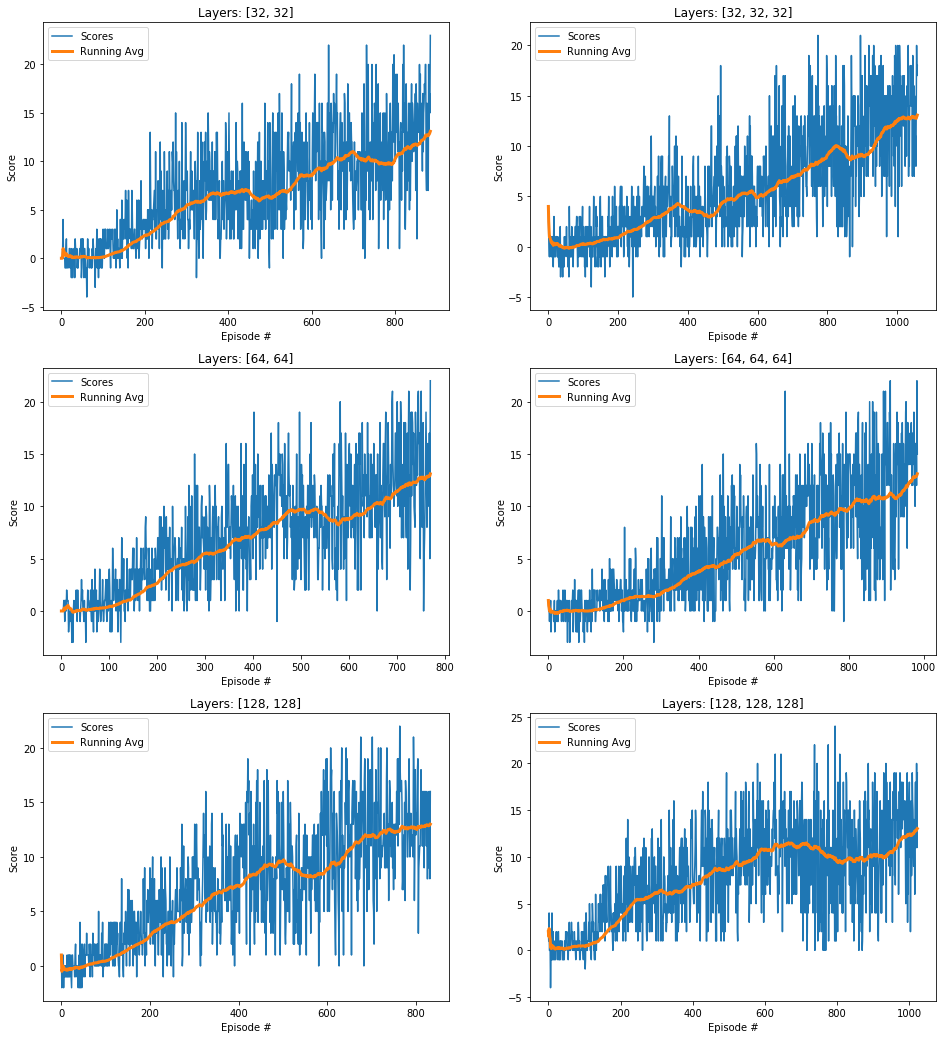

In [21]:
# plot the results
fig = plt.figure(figsize=(16, 18))
for i, model in enumerate(models):
    ax = fig.add_subplot(3,2,i+1)
    results = all_results[i]
    plt.plot(np.arange(len(results)), [result[0] for result in results])
    plt.plot(np.arange(len(results)), [result[1] for result in results], linewidth=3)
    plt.title('Layers: '+repr(model))
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(['Scores', 'Running Avg'], loc='upper left')
plt.show()

There are a few conclusions that can be drawn:

1. Adding layers to the NN seems to degrade the performance of the agent. All three models perform worse when moving from a 2-hidden layers to 3-hidden layers architecture. Upon reflection that makes sense because the additional layer means additional parameters that need to be trained. And that requires additional training data, that in this case means more episodes are required to be experienced.

2. The larger number of neurons the more pronounced corrections in training. You can see that the networks with 128 neurons have siginificant corrections where the average score dips significantly on the average graph. This is a sign of overfitting early in the training that has to be corrected by changing a significant number of weights, during which time the network behaves significantly worse. So, for this case the "bigger is better" doesn't seem to be a good idea.

3. Also, you can see that, as the number of neurons increases, the range of results (the blue areas) seem to also increase suggesting a large variation of results obtained during execution. In principle, we would like this variation to stay under control and even to reduce if possible.

4. Although the number of parameters grows with a factor of 4 between netwroks (from [32.32] to [64,64] the aproximative number of paramaters is about 4 times bigger, and that is the case for [128,128] versus [64,64]) the processing times increase only by a fraction: from [32,32] to [64,64] the average processing time for an episode increases only by 1.9% while from [64,64] to [128,128] the increase is 8.9% still very low compared with the massive change in the number of parameters. The reason for this seems to be the fact that the bottleneck here is the Unity simulator that needs the time to compute the states and render the image.

### Impact of the Training Parameters

We will now look at the impact of certain training paraemters on the training results. We will look expecially at the impact of `batch_size` and `update_every` on the performance.

**Note:** running this cell will take more than one hour as we are running training 9 times. You can skip running this cell in the Jupyter Notebook and go to the next cell that loads the data from the files saved from my run.

In [22]:
# we will consider three batch_size options and
# three update_every ones
batch_sizes = [32, 64, 128]
update_everys = [4, 8, 16]

for batch_size in batch_sizes:
    for update_every in update_everys:
        
        print('Training for batch_size: {:d}, update_every: {:d}'.format(batch_size,
                                                                         update_every))
        
        # we use a [64, 64] NN but we configure the
        # batch_size and the update_every
        agent = DQNAgent(state_size, action_size, [64, 64], 
                         seed=0,
                         batch_size=batch_size,
                         update_every=update_every)
        # name for saving the models
        postfix = '{:d}-{:d}-BatchEveryImpact.pth'.format(batch_size,
                                                          update_every)
        results = trainer(agent, verbose=False, 
                          save=True, 
                          save_postfix=postfix)
        # save the results for processing
        filename = 'results/DQNAgent-{:d}-{:d}-BatchEveryImpact.dat'.format(batch_size,
                                                                           update_every)
        f = open(filename, 'wb')
        pickle.dump(results, f)
        f.close()

Training for batch_size: 32, update_every: 4
Episode 724	Average Score: 13.02	Episode: 0.758s	Running: 582.4s
Environment solved in 724 episodes!	Average Score: 13.02	 In 582.4s
Training for batch_size: 32, update_every: 8
Episode 666	Average Score: 13.03	Episode: 0.728s	Running: 515.9s
Environment solved in 666 episodes!	Average Score: 13.03	 In 515.9s
Training for batch_size: 32, update_every: 16
Episode 851	Average Score: 13.03	Episode: 0.728s	Running: 667.7s
Environment solved in 851 episodes!	Average Score: 13.03	 In 667.7s
Training for batch_size: 64, update_every: 4
Episode 591	Average Score: 13.00	Episode: 0.886s	Running: 504.2s
Environment solved in 591 episodes!	Average Score: 13.00	 In 504.2s
Training for batch_size: 64, update_every: 8
Episode 726	Average Score: 13.01	Episode: 0.725s	Running: 580.3s
Environment solved in 726 episodes!	Average Score: 13.01	 In 580.3s
Training for batch_size: 64, update_every: 16
Episode 892	Average Score: 13.04	Episode: 0.836s	Running: 686.0

Below I have summarized the results I have obtained when running the 9 training sessions:

| Batch     | Update.    |  Episodes    |   Running Time[s] | Avg./Episode[s]|
|:---------:|:----------:|-------------:|------------------:|---------------:|
|32         |4           | 724          | 582               |          0.804 |
|32         |8           | 666          | 516               |          0.775 |
|32         |16          | 851          | 668               |          0.785 |
|64         |4           | **591**      | **504**           |          0.853 |
|64         |8           | 726          | 580               |          0.799 |
|64         |16          | 892          | 686               |          0.769 |
|128        |4           | 707          | 654               |          0.925 |
|128        |8           | 595          | 513               |          0.862 |
|128        |16          | 1053         | 828               |          0.786 |


A more convenient way to look at the data would be for the **number of episodes**:

| Batch/Update | 4       | 8       | 16      |
|--------------|---------|---------|---------|
| 32           | 724     | 666     | 851     |
| 64           | 591     | 726     | 892     |
| 128          | 707     | 595     | 1053    |

And for the **running time**:

| Batch/Update | 4       | 8       | 16      |
|--------------|---------|---------|---------|
| 32           | 582     | 516     | 668     |
| 64           | 504     | 580     | 686     |
| 128          | 654     | 513     | 828     |


Before we start analyzing this data let's also plot the results of the trainings. We will load the training results from the file and plot them together. If you skipped the training step above you can still run the following cell and the training results from my session will be loaded and plotted.

In [23]:
# load the data from files
all_results = []
for batch_size in batch_sizes:
    for update_every in update_everys:
        filename = 'results/DQNAgent-{:d}-{:d}-BatchEveryImpact.dat'.format(batch_size,
                                                                           update_every)
        f = open(filename, 'rb')
        results = pickle.load(f)
        all_results.append(results)

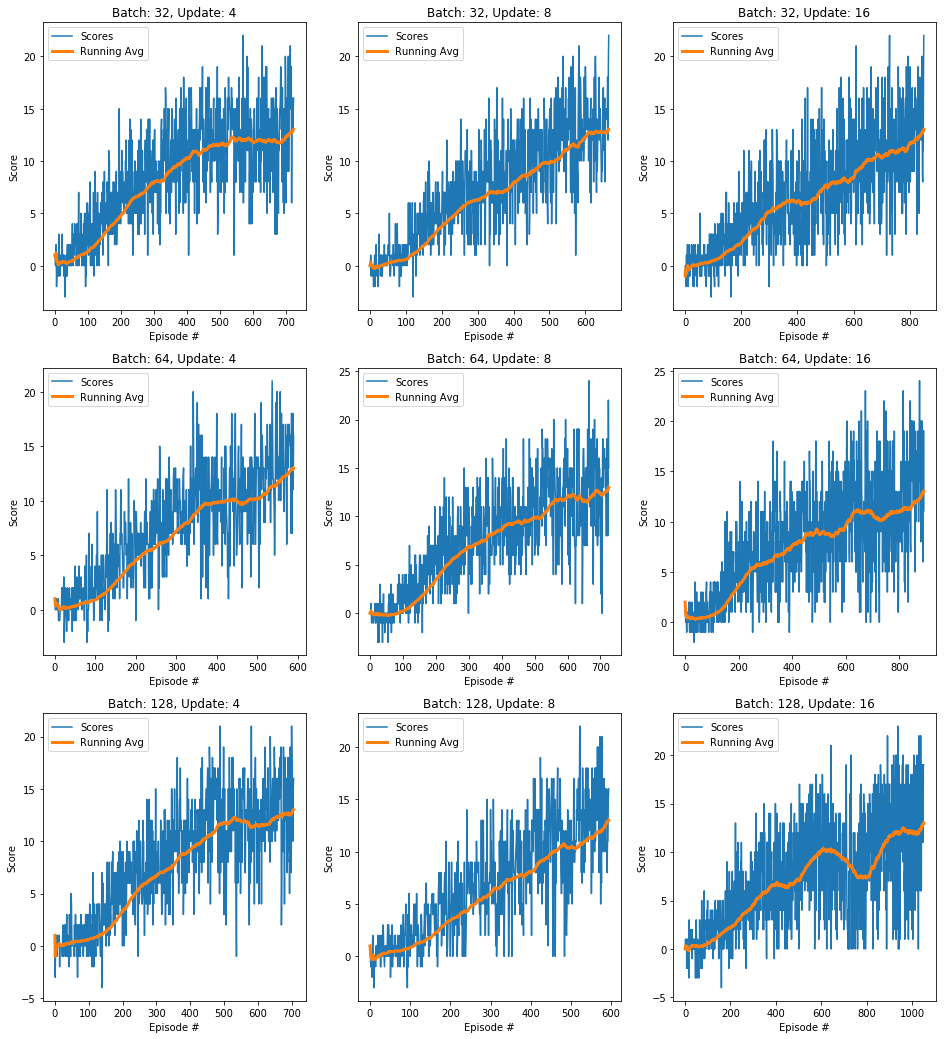

In [25]:
# plot the results
fig = plt.figure(figsize=(16, 18))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    results = all_results[i]
    plt.plot(np.arange(len(results)), [result[0] for result in results])
    plt.plot(np.arange(len(results)), [result[1] for result in results], linewidth=3)
    b = batch_sizes[i // 3]
    u = update_everys[i % 3]
    plt.title('Batch: {:d}, Update: {:d}'.format(b, u))
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(['Scores', 'Running Avg'], loc='upper left')
plt.show()

### Analyzing the Data

First let's clarify that the results we have obtained above migt be not a fair representation of the performance of the model with the parameters chosen. The reality is that the environment properties and the random nature of the experiances means any particular run of training might be subject to large variances in perfomance. In our case we have only run one single training session for each combination of parameters and therefore we should be careful about the statements we meke. A significantly better approach is to run a set of trainings for each set of parameters and use the average as well as the standard deviations when doing the comparisons. Unfortunatelly that would take a significant amount of time and I did not have that available when preparing this solution.

Nevertheless we will try to see if there are any patterns in the results above that we could explain and maybe use in order to decide on the most optimal parameters to use for a real implementation.

1. Changing `update_every` from 8 to 16 seems to have a negative impact on the number of episodes as well on the training duration. This seems intuitive as with higher `update_every` parameters we are likely to experiance more events for the same number of training data to pass through the NN for learning. 

2. The impact of changing `update_every` from 4 to 8 is not that clear: in two instances (for batch of 32 and 128) we see an improvement (reduction) in both the number of episodes and the training time, while for the batch of 64 we see a degradation. The worse performace with an `update_every` of 4 could be down to the 'moving target' syndrome that we mentioned when analysing the SimpleAgent in the first part of this document.

3. `batch_size` of 128 seems to produce more unstable training paths: the average is more likely to suffer significant drops in value and the model needs additional time to 'relearn' and recover. This seems to be also relfected in the actual scores per episode (the blue line in the graphs) that, in the case of 128 batch size, seem to significantly more offen hit lower towards a score of 0 than the 64 ot 32 batch sizes, indicating perhaps an overfitting of certain positive situations on the expense of others.

## Future Work

Reinforcement Learning is one of the hottest topic in Machine Learning at the moment and some of the methods inluded in this project are state-of-the-art in the field.

Personnaly, what interests me is the advance of Reinforcement Learning through the parallels with the real-life neurological counterparts, a parallel that could benefit both fields in equal manner. For instance the **replay memory** included in the DQN model resembles significantly with the role that Hypocampus plays in the establishment of memories and learning of skills.

The two nerual networks used in the DQN model ('local' and 'target') at first don't seem to have an equvalent presence in the human brain (unless we are all schizophrenic!), but a closer examination of the way the cortical columms process data reflects a bi-directional flow: **upwards** from lower layers (processing lower complexity representations) to higher layers (representing more complex ones), but also a **downwards** flow from higher layers to lower layers. There are increasing oppinions that the downward flow corresponds with a propagation of **predictions** while the upward flow corresponds with a propagation of **error signal**. This is different from the current Neural Networks models that always propagate information through every layer and use backpropagation algorithms to adjust the weights of the neurons during training. The interesting part obout Reinforcement Learning is that the two items, **prediction** and **error**, are both present under the form of **Expectation about the next state** and the **Temporal Difference (TD)** while the recurrent nature of the Bellman equations are reflected in the recurrent structure of the connections between layers.

A striking difference between the current NN models and the way the brain works is manifested in the way the learning process works. While digital NNs use backpropagation and *lots* of mathematical computations (as felt in exponential growth in the demand for high performance computing, like GPU processing), biological neurons use *very* elegant solutions, equally elegant described by the [Hebbian learning](https://en.wikipedia.org/wiki/Hebbian_theory) rule: "neurons that fire together wire togehter". Current research suggests that certain ion channels are partially blocked by Magnesium ions reducing the flow of current. When a synchronuous firing of the receptor neuron and the source neuron happens, the Mg ion is "popped" from the ion channel allowing a surge in the current that in turn triggers the mechanisms leading to Long Term Potentiation (LTP) - see Sterling, Laughlin - "Principles of Neural Design", MIT Press 2017.

In this context I have summarised some of the possible future work realted to the RL algorithms:

### Imediate Work

One of the imediate work that can be done on the back of this project it a more thorough **evaluation of the influence of learning parameters on the performance** of training and finding explanations for their behaviour. Since the training times can be quite long and, due to the stochastic nature of the enviromnment, we would need to execute it multiple times for the same set of parameters in order to eliminate the impact of such randomness, this activity might take many days of training.

Another area of quick improvement would relate to the way the actions are taken by the Agent (currently purely $\epsilon$-greedey with a equal probability of selecting the action outside the greedy choice). Another option is to use a policy that makes the **choice based on a normalization** of all the Q values accross a non-zero to 1 one range, so that all actions have a non-zero probablity of being selected, even the worst one.

### Medium Term Work

The course introduced [Prioritised Experience Replay](https://arxiv.org/abs/1511.05952) that changes the way the experiences are sampled for learning, using a sampling priority for each experience that is derived from the TD error associated with that particular experience, instead of equal probability as in the case of the original DQN model. This is an approach that has equivalance in the human brain although in a slightly different manner: the Prioritised Exprience Replay still stores all experiences and uses the TD error later in the sampling of these experiences for learning. The brain (or Hypocampus to be more specific) seems to perform this filtering at the storage time, discarding the experiences that have a very low "surprise factor" while storing the ones with high TD errors (and therefore having better usability in learning). For digital models we don't seem to be too concerned with using "memory" to store random types of information, while in the brain this is a very expensive activity and it is performed with very significant caution. Therefore one improvement we could do is to incorporate a check **before storing an experience** in the memory and discard the ones for which the absolute value of the TD error is below a certain threshold.

This approach becomes even more important when experiences contain a lot of information, for instance they are based on visual information, or the state space is very large.

In the case of state space that is driven by visual input (like in the case of the challenge of this project) a better solution is to store not the original raw input from the environment (the image), but the **information produced on a higher layer** in the NN. This parallels how the Hypocampus receives its inputs, not directly from the sensory pathways (ex, the optic nerve) but rahter from the [Entorhinal cortex](https://en.wikipedia.org/wiki/Entorhinal_cortex) that itself receives highly processed inforation from all sensory areas. Using this approach the requirements for the Replay Memory can significantly be reduced and later the replay will only need to be performed in the upper layers of the network.


### Long Term Work

A confusing and rather embarasing problem realted to the theory of RL is the deliberate interchange between the terms **state** and **observation**. This comes from the fact that the current models are built with a particular task in mind and the two are seen as synonyms. This is acceptable for task oriented models, but this introduces significant limitations for the developement of Genral AI. Specifically I would consider using the term **state** (*s*) to represent the information in the environment while **obesrvation** (*o*) represents the information that the Agent receives from the Environment through the sensory mediums availabe to the Agent. It is important to notice that *s* is not known (but can be aproximated as we will see later) and *o* is something that entirely depends on the Agent's abilities (like visual, auditory, etc.), not the Enviromment. The Agent will use *o* to produce a representation of *s* that we denote as *$\bar s$* as well as a reward *r*. Notice that the reward is not provided by the environment as in the classical RL, but is derived by the Agent from the observations *o*, thus making the process more flexible over time (reward interpretation changes over time, isn't?).

There are several important impacts these changes will have:

1. the state space *s* can be extremely large (the Universe) but we are not affected by this; we can still produce a aproximate version *$\bar s$*, limited only by the capacity of the NN model we implement

2. althogh *o* can stay the same over time, in terms of structure (ex. we only see with our own eyes in the same way for the majority of our life), as long as the NN that processes the information and determines *$\bar s$* is capable of recurrence we can increase the state space for *$\bar s$* almost without limits (other than the ones imposed by the capacity of the NN). For instance I can use my visual sense to look at the sky at night and study the movement of Jupyter. This is one of the (temporary representations I have *$\bar s$*). Later I might use a telescope to observe Jupyter. This time the processing is in stages: I first observe the telescope that triggers the activation of a state corresponding to this *context* so that when I look at Jupyter the enhanced state space that I develop increases the accuracy with which is reflecting the actual "real" *s* (for eaxmaple I can see that Jupyter has satelites). This chaining of context that allows me to combine the *$\bar s$* with *o* to produce even more complex *$\bar s$* creates a powerful mechanism for representing more complex concepts, a primary requirement for General AI.

3. the faxct that rewards are no longer provided by the environment, but rather evaluated by the Agent from the observations *o* is a significant advantage. A General AI would need the capability to develop new rewards and to decay the evaluation of previous rewards in order to evolve. Changes in the reward evaluation could result in enforceing certain behaviours or inhibiting them, which in turn can lead to additional exploratory searches and developement of new behavours.

As mentioned at the begining of this chapter a very important change to the way RL is implemented with DNN would be the replication of the bidirectional flow NN (downward - prediction propagation / upwards - error propagation) into the model. This would completely reverse the way the information flows: currently the model receives the information from the environment and propagates it upward. With the bidirectional flow the network constantly tries to stay one step ahead by predicting the next state (and propagating it downwards) while the upwards flow (fueled by the observations from the environment) propagate the error of this prediction up. This network now would be a layered representation of more and more abstract concepts. This model is a very important element for the next feature I describe below.

The approach taken by the DQN to "replay" from memmory at certain time steps has also an interesting parallel with another funtion of the human brain: **sleep**. What we can additionally learn from the studies related to sleep is that there are different phases of sleep with clear differences on the brain activity. During **deep sleep** the brain activity is mainly synchronic (high amplitude of low frequency waves or [delta waves](https://en.wikipedia.org/wiki/Delta_wave)) while in **REM sleep** the waves are very similar to the ones seen in awake state. The studies suggest that during the deep sleep we replay (almost in a "supervised learning" mode) the experiences from the past and the parts of the brain network that have to process that information are trained (learn) those experiences similar to an "exploatation" mode, while in REM sleep the brain seems to be performing a more "exploratory" activity where many possible prodictions are considered simultaneously. This way of processing in the NN can be seen as an direct result of using the bidirectional flow NN: in deep sleep we keep the *focus* (we limit the number of higher layers that can predict by rasing a threshlold that introduces horizontal inhibitions) and use as input in the lower layers the experience stored in the Replay Memory (Hypocampus). The network will end up processing in a synchrounous mode the stored experience almost as a supervised learning model. In REM sleep the only thing we need to do is to lower the threshold for horizontal inhibitions and allow a reduced flow from the sensory information to propagate up. The result will be an exploratory state where upper layers are allowed to propagate downwards their predictions while the lower layers "confabulate" errors through the combination of existing experience in the Replay Memory and limited sensory input.

As a final area of interest, the depicted NN model is exptremely suitable for deployment on **neuromorphic hardware**. Learning on these networks no longer requires backpropagation and massive tensor calculations. Instead they are built in the nature of the artifical neurons reflecting the Hebbian Learning principle. The implications from an energy consumption perspective are significant and would bring us in the "practical range" of power consuption for a General AI model.